In [1]:
import os
os.sys.path.append('./torch-cam')

In [2]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import show_result_pyplot
from mmdet.models import build_detector
# Choose to use a config and initialize the detector
config = 'configs/gfl/gfl_r50_fpn_1x_coco.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/gfl_r50_fpn_1x_coco_20200629_121244-25944287.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

/home/ubuntu/anaconda3/envs/qjc/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
/home/ubuntu/qjc/mmattack/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: checkpoints/gfl_r50_fpn_1x_coco_20200629_121244-25944287.pth


GFL(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): 

In [3]:
from pathlib import Path

import mmcv
import numpy as np
import torch
from mmcv.ops import RoIPool
from mmcv.parallel import collate, scatter
from mmcv.runner import load_checkpoint

from mmdet.core import get_classes
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.models import build_detector

def data_process(model, imgs):
    if isinstance(imgs, (list, tuple)):
        is_batch = True
    else:
        imgs = [imgs]
        is_batch = False

    cfg = model.cfg
    device = next(model.parameters()).device  # model device

    if isinstance(imgs[0], np.ndarray):
        cfg = cfg.copy()
        # set loading pipeline type
        cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

    cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
    test_pipeline = Compose(cfg.data.test.pipeline)

    datas = []
    for img in imgs:
        # prepare data
        if isinstance(img, np.ndarray):
            # directly add img
            data = dict(img=img)
        else:
            # add information into dict
            data = dict(img_info=dict(filename=img), img_prefix=None)
        # build the data pipeline
        data = test_pipeline(data)
        datas.append(data)

    data = collate(datas, samples_per_gpu=len(imgs))
    # just get the actual data from DataContainer
    data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
    data['img'] = [img.data[0] for img in data['img']]

    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]
    else:
        for m in model.modules():
            assert not isinstance(
                m, RoIPool
            ), 'CPU inference with RoIPool is not supported currently.'

    return is_batch, data

def inference_detector(model, imgs):
    """Inference image(s) with the detector.

    Args:
        model (nn.Module): The loaded detector.
        imgs (str/ndarray or list[str/ndarray] or tuple[str/ndarray]):
           Either image files or loaded images.

    Returns:
        If imgs is a list or tuple, the same length list type results
        will be returned, otherwise return the detection results directly.
    """

    is_batch, data = data_process(model, imgs)
    # forward the model
    results = model(return_loss=False, rescale=False, **data)
    if not is_batch:
        return results[0], data
    else:
        return results, data

In [4]:
from torchcam.methods import GradCAM
cam_extractor = GradCAM(model, ['backbone.layer4'])

In [13]:
imgs = 'dog_cat.jpg'

In [14]:
att_results, data = inference_detector(model, imgs)
att_idx = att_results[0][:, 4] > 0.3
activation_map = []
if att_idx.any():
    for cls, logit in zip(att_results[1][att_idx], att_results[2][att_idx]):
        activation_map.append(cam_extractor(cls.item(), logit.unsqueeze(0), normalized = False))

In [15]:
print(activation_map[1][0].shape)

torch.Size([1, 25, 25])


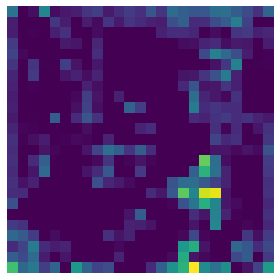

In [16]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0][0].clone().detach().squeeze(0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

In [17]:
import numpy as np
import cv2
def scale_cam_image(img, target_size=None):
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(img, target_size)
        return img.astype(np.float32)

In [18]:
print(data['img'][0].shape)

torch.Size([1, 3, 800, 800])


In [56]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = True,
                      colormap: int = cv2.COLORMAP_JET,
                      image_weight: float = 0.7) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
    :returns: The default image with the cam overlay.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    if image_weight < 0 or image_weight > 1:
        raise Exception(
            f"image_weight should be in the range [0, 1].\
                Got: {image_weight}")

    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

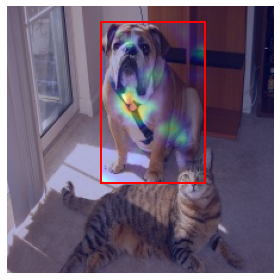

In [62]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.patches as patches
import cv2
import numpy as np
# Resize the CAM and overlay it
img1 = mmcv.imread(imgs)

img1 = img1[...,::-1] / 255.0
h, w = img1.shape[0], img1.shape[1]
target_size = (w, h)
cam_img = activation_map[1][0].clone().detach().squeeze(0).cpu().numpy()
cam_img = np.maximum(cam_img, 0)

cam_img = scale_cam_image(cam_img, target_size)

bbox = att_results[0][att_idx][0][:4].clone().detach().cpu().numpy().astype(np.int32)
trans_h, trans_w = data['img_metas'][0][0]['img_shape'][0], data['img_metas'][0][0]['img_shape'][1]
stride_h, stride_w = trans_h / h, trans_w / w

bbox[0::2] = bbox[0::2] / stride_w
bbox[1::2] = bbox[1::2] / stride_h

x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)

renormalized_cam = np.zeros((img1.shape[0], img1.shape[1]), dtype=np.float32)

renormalized_cam[y1:y2,x1:x2] = scale_cam_image(cam_img[y1:y2,x1:x2].copy())
renormalized_cam = scale_cam_image(renormalized_cam)
result_img = show_cam_on_image(img1, renormalized_cam)
# Display it
plt.imshow(result_img); plt.axis('off'); plt.tight_layout(); plt.show()

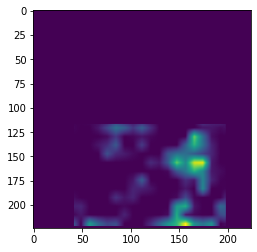

In [58]:
plt.imshow(renormalized_cam)

In [ ]:
# .......

In [3]:
!python vis_cam.py dog_cat.jpg configs/gfl/gfl_r50_fpn_1x_coco.py checkpoints/gfl_r50_fpn_1x_coco_20200629_121244-25944287.pth --out-dir my_cam

/home/ubuntu/anaconda3/envs/qjc/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
/home/ubuntu/qjc/mmattack/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
load checkpoint from local path: checkpoints/gfl_r50_fpn_1x_coco_20200629_121244-25944287.pth
/home/ubuntu/qjc/mmattack/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. 

In [29]:
!python generate_attack_test.py MyAttack_Vanishing configs/gfl/gfl_r50_fpn_1x_coco.py checkpoints/gfl_r50_fpn_1x_coco_20200629_121244-25944287.pth

/home/ubuntu/anaconda3/envs/qjc/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '
/home/ubuntu/qjc/mmattack/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '
load checkpoint from local path: checkpoints/gfl_r50_fpn_1x_coco_20200629_121244-25944287.pth
0
picture---------------- 1
/home/ubuntu/qjc/mmattack/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatB

loss_cam   5.973456609353889e-07 --loss_pred   12.66653060913086
iter---- 1
loss_cam   5.101650003780378e-06 --loss_pred   1.8556221723556519
iter---- 2
loss_cam   8.020992936508264e-06 --loss_pred   0.5878617763519287
iter---- 3
loss_cam   7.449582426488632e-06 --loss_pred   0.44209420680999756
iter---- 4
loss_cam   5.436133960756706e-06 --loss_pred   0.26591259241104126
iter---- 5
loss_cam   3.939514954254264e-06 --loss_pred   0.9815465211868286
iter---- 6
loss_cam   6.989238954702159e-06 --loss_pred   0.1082630380988121
iter---- 7
loss_cam   2.3676466298638843e-06 --loss_pred   0.048224493861198425
iter---- 8
loss_cam   5.858839358552359e-06 --loss_pred   0.03678778558969498
iter---- 9
loss_cam   9.501329259364866e-06 --loss_pred   0.019195526838302612
9
iter---- 0
loss_cam   1.4343517484860513e-08 --loss_pred   6.982424736022949
iter---- 1
loss_cam   1.2167406566732097e-06 --loss_pred   2.573011636734009
iter---- 2
loss_cam   4.7524963520118035e-06 --loss_pred   0.5500124096870422


iter---- 5
loss_cam   3.0932133086025715e-05 --loss_pred   0.23790715634822845
iter---- 6
loss_cam   2.3455875634681433e-05 --loss_pred   0.09202559292316437
iter---- 7
loss_cam   1.377391890855506e-05 --loss_pred   0.40463125705718994
iter---- 8
loss_cam   3.9808874134905636e-05 --loss_pred   0.13837061822414398
iter---- 9
loss_cam   1.866656748461537e-05 --loss_pred   0.02166753076016903
19
iter---- 0
loss_cam   4.216265026002475e-08 --loss_pred   15.485485076904297
iter---- 1
loss_cam   4.01019269702374e-06 --loss_pred   3.0616931915283203
iter---- 2
loss_cam   1.1757054380723275e-05 --loss_pred   1.3360811471939087
iter---- 3
loss_cam   1.0926552931778133e-05 --loss_pred   0.7693944573402405
iter---- 4
loss_cam   1.1917335314137745e-06 --loss_pred   2.552563190460205
iter---- 5
loss_cam   3.707861424118164e-06 --loss_pred   0.343491792678833
iter---- 6
loss_cam   4.92965045850724e-06 --loss_pred   0.34246546030044556
iter---- 7
loss_cam   6.941904302948387e-06 --loss_pred   1.99622

29
iter---- 0
loss_cam   2.949112456462899e-07 --loss_pred   8.172083854675293
iter---- 1
loss_cam   4.06851398793151e-07 --loss_pred   7.185606002807617
iter---- 2
loss_cam   2.317018925168668e-06 --loss_pred   2.0490493774414062
iter---- 3
loss_cam   4.681673999584746e-06 --loss_pred   0.9334642887115479
iter---- 4
loss_cam   2.2458912098954897e-06 --loss_pred   1.0160284042358398
iter---- 5
loss_cam   5.357942427508533e-06 --loss_pred   0.8316749930381775
iter---- 6
loss_cam   3.080316901105107e-06 --loss_pred   0.10303273797035217
iter---- 7
loss_cam   1.2265544455658528e-06 --loss_pred   0.1602053940296173
iter---- 8
loss_cam   7.499571438529529e-06 --loss_pred   0.13206155598163605
iter---- 9
loss_cam   6.111553148002713e-07 --loss_pred   0.15531213581562042
30
picture---------------- 31
iter---- 0
loss_cam   8.409382523666409e-09 --loss_pred   47.300933837890625
iter---- 1
loss_cam   9.113163628171606e-07 --loss_pred   11.671835899353027
iter---- 2
loss_cam   2.8330086934147403e

loss_cam   2.585873517091386e-06 --loss_pred   0.408862829208374
iter---- 6
loss_cam   1.67025991686387e-05 --loss_pred   0.5116021037101746
iter---- 7
loss_cam   5.898884865018772e-06 --loss_pred   0.20480015873908997
iter---- 8
loss_cam   5.528829206014052e-06 --loss_pred   0.16128213703632355
iter---- 9
loss_cam   1.524580056866398e-05 --loss_pred   0.15333133935928345
40
picture---------------- 41
iter---- 0
loss_cam   4.990154423012427e-08 --loss_pred   11.925257682800293
iter---- 1
loss_cam   1.7766092241799925e-06 --loss_pred   4.972548007965088
iter---- 2
loss_cam   9.247145499102771e-06 --loss_pred   1.90256667137146
iter---- 3
loss_cam   5.926933226874098e-06 --loss_pred   1.6692543029785156
iter---- 4
loss_cam   6.791040959797101e-06 --loss_pred   0.4969867169857025
iter---- 5
loss_cam   3.4049401165248128e-06 --loss_pred   0.1651775985956192
iter---- 6
loss_cam   5.8801415434572846e-06 --loss_pred   0.10019278526306152
iter---- 7
loss_cam   5.375452019507065e-06 --loss_pred

50
picture---------------- 51
iter---- 0
loss_cam   1.3164791923259145e-08 --loss_pred   49.38286590576172
iter---- 1
loss_cam   4.017053470306564e-06 --loss_pred   13.575579643249512
iter---- 2
loss_cam   6.76389799991739e-06 --loss_pred   4.358921051025391
iter---- 3
loss_cam   1.1548746442713309e-05 --loss_pred   0.9534945487976074
iter---- 4
loss_cam   6.309915534075117e-06 --loss_pred   0.33875536918640137
iter---- 5
loss_cam   1.4434504919336177e-05 --loss_pred   0.3539635241031647
iter---- 6
loss_cam   6.6361699282424524e-06 --loss_pred   0.8840349912643433
iter---- 7
loss_cam   6.707998636557022e-06 --loss_pred   1.0971858501434326
iter---- 8
loss_cam   6.35634296486387e-06 --loss_pred   0.14884112775325775
iter---- 9
loss_cam   9.544308340991847e-06 --loss_pred   0.11282604932785034
51
iter---- 0
loss_cam   3.1756593443788006e-07 --loss_pred   5.056461811065674
iter---- 1
loss_cam   6.702377959300065e-06 --loss_pred   2.969425678253174
iter---- 2
loss_cam   2.8437862056307495e

loss_cam   1.6244383004959673e-05 --loss_pred   0.6389394402503967
iter---- 6
loss_cam   1.0494206435396336e-05 --loss_pred   0.2610199749469757
iter---- 7
loss_cam   1.472558233217569e-05 --loss_pred   0.12188145518302917
iter---- 8
loss_cam   1.1217717656109016e-05 --loss_pred   0.0334014892578125
iter---- 9
loss_cam   8.165290637407452e-06 --loss_pred   0.030660247430205345
61
iter---- 0
loss_cam   1.5899436789368337e-07 --loss_pred   30.968135833740234
iter---- 1
loss_cam   8.010374585865065e-06 --loss_pred   6.327549457550049
iter---- 2
loss_cam   1.0445505722600501e-05 --loss_pred   6.632970809936523
iter---- 3
loss_cam   1.414078360539861e-05 --loss_pred   3.7013044357299805
iter---- 4
loss_cam   2.1466572434292175e-05 --loss_pred   6.955007076263428
iter---- 5
loss_cam   1.2512908142525703e-05 --loss_pred   3.981027603149414
iter---- 6
loss_cam   1.7345517335343175e-05 --loss_pred   1.1393280029296875
iter---- 7
loss_cam   1.3987991223984864e-05 --loss_pred   1.4032825231552124

71
iter---- 0
loss_cam   1.5345706927405445e-08 --loss_pred   67.7178726196289
iter---- 1
loss_cam   2.4020109776756726e-06 --loss_pred   28.593002319335938
iter---- 2
loss_cam   2.304490180904395e-06 --loss_pred   13.250000953674316
iter---- 3
loss_cam   4.040848580189049e-06 --loss_pred   3.053730010986328
iter---- 4
loss_cam   3.5024772842007224e-06 --loss_pred   2.6862599849700928
iter---- 5
loss_cam   6.947156634851126e-06 --loss_pred   1.1984858512878418
iter---- 6
loss_cam   5.438200787466485e-06 --loss_pred   0.9940629005432129
iter---- 7
loss_cam   5.050539130024845e-06 --loss_pred   0.1745694875717163
iter---- 8
loss_cam   3.0083170713623986e-05 --loss_pred   0.08693379163742065
iter---- 9
loss_cam   7.100861239450751e-06 --loss_pred   0.21070429682731628
72
iter---- 0
loss_cam   2.3679676530719007e-07 --loss_pred   6.496514797210693
iter---- 1
loss_cam   3.108675446128473e-05 --loss_pred   6.578552722930908
iter---- 2
loss_cam   5.320390482665971e-05 --loss_pred   2.94143342

loss_cam   1.38269824674353e-05 --loss_pred   0.3456287682056427
iter---- 6
loss_cam   1.7058457160601392e-05 --loss_pred   0.07434161007404327
iter---- 7
loss_cam   1.0759672477433924e-05 --loss_pred   2.4741334915161133
iter---- 8
loss_cam   5.073786451248452e-05 --loss_pred   1.0128504037857056
iter---- 9
loss_cam   9.23224251891952e-06 --loss_pred   0.19756890833377838
82
iter---- 0
loss_cam   1.7413867681170814e-07 --loss_pred   39.5996208190918
iter---- 1
loss_cam   1.1729115385605837e-06 --loss_pred   17.619598388671875
iter---- 2
loss_cam   4.713158887170721e-06 --loss_pred   4.77647590637207
iter---- 3
loss_cam   7.243981599458493e-06 --loss_pred   1.7535219192504883
iter---- 4
loss_cam   1.5678613635827787e-05 --loss_pred   0.7262824177742004
iter---- 5
loss_cam   5.789693204860669e-06 --loss_pred   0.7936211824417114
iter---- 6
loss_cam   1.0876787200686522e-05 --loss_pred   1.3290492296218872
iter---- 7
loss_cam   8.704490028321743e-06 --loss_pred   0.9476418495178223
iter-

loss_cam   6.537717922583397e-09 --loss_pred   39.56395721435547
iter---- 1
loss_cam   4.5088756905897753e-07 --loss_pred   15.896242141723633
iter---- 2
loss_cam   1.7596340740055894e-06 --loss_pred   4.0186052322387695
iter---- 3
loss_cam   1.5326918401115108e-06 --loss_pred   2.5529520511627197
iter---- 4
loss_cam   1.7217904542121687e-06 --loss_pred   0.25870493054389954
iter---- 5
loss_cam   4.075719971297076e-06 --loss_pred   0.23921509087085724
iter---- 6
loss_cam   2.1750333871750627e-06 --loss_pred   0.053223200142383575
iter---- 7
loss_cam   3.0169942419888685e-06 --loss_pred   0.09792102873325348
iter---- 8
loss_cam   2.2166389044286916e-06 --loss_pred   0.06438379734754562
iter---- 9
loss_cam   4.7068556341400836e-06 --loss_pred   0.20023582875728607
93
iter---- 0
loss_cam   1.9770926229512042e-08 --loss_pred   57.4398193359375
iter---- 1
loss_cam   3.593925839595613e-06 --loss_pred   20.80489158630371
iter---- 2
loss_cam   6.779520845157094e-06 --loss_pred   13.24011516571

loss_cam   5.396622782427585e-06 --loss_pred   0.25447747111320496
iter---- 6
loss_cam   8.994836207421031e-06 --loss_pred   0.10992699861526489
iter---- 7
loss_cam   1.3235470532890758e-06 --loss_pred   0.02622552588582039
iter---- 8
loss_cam   6.942271284060553e-06 --loss_pred   0.25144368410110474
iter---- 9
loss_cam   1.13233336378471e-05 --loss_pred   0.018408553674817085
103
iter---- 0
loss_cam   4.256903096688802e-08 --loss_pred   9.696763038635254
iter---- 1
loss_cam   8.337431609106716e-06 --loss_pred   2.3793160915374756
iter---- 2
loss_cam   1.2053186765115242e-05 --loss_pred   0.9000963568687439
iter---- 3
loss_cam   1.3925665598435444e-06 --loss_pred   0.6030391454696655
iter---- 4
loss_cam   2.699039214348886e-06 --loss_pred   0.7494114637374878
iter---- 5
loss_cam   9.253309144696686e-06 --loss_pred   0.048882149159908295
iter---- 6
loss_cam   5.216240879235556e-06 --loss_pred   0.02748727612197399
iter---- 7
loss_cam   1.9185197743354365e-05 --loss_pred   0.023740245029

iter---- 0
loss_cam   8.609701396267155e-09 --loss_pred   9.091621398925781
iter---- 1
loss_cam   4.0114071452990174e-05 --loss_pred   5.817861080169678
iter---- 2
loss_cam   6.308958745648852e-06 --loss_pred   3.2489256858825684
iter---- 3
loss_cam   1.2462699487514328e-05 --loss_pred   0.5292097330093384
iter---- 4
loss_cam   5.111416157888016e-06 --loss_pred   0.33859261870384216
iter---- 5
loss_cam   2.109189153998159e-05 --loss_pred   0.22611939907073975
iter---- 6
loss_cam   1.2078086911060382e-05 --loss_pred   0.15978246927261353
iter---- 7
loss_cam   1.650168269407004e-05 --loss_pred   0.33048850297927856
iter---- 8
loss_cam   4.849583547184011e-06 --loss_pred   0.32182949781417847
iter---- 9
loss_cam   9.718955880089197e-06 --loss_pred   0.1139160692691803
114
iter---- 0
loss_cam   2.7435980598511378e-08 --loss_pred   4.966948509216309
iter---- 1
loss_cam   1.97677923097217e-06 --loss_pred   2.1613407135009766
iter---- 2
loss_cam   5.088496891403338e-06 --loss_pred   2.7931182

loss_cam   1.084789982996881e-05 --loss_pred   0.330625057220459
iter---- 6
loss_cam   3.625643557825242e-06 --loss_pred   0.14284305274486542
iter---- 7
loss_cam   5.343628799892031e-06 --loss_pred   0.23657731711864471
iter---- 8
loss_cam   8.431188689428382e-06 --loss_pred   0.037768445909023285
iter---- 9
loss_cam   2.5418623863515677e-06 --loss_pred   0.008576682768762112
124
iter---- 0
loss_cam   7.762843523551055e-08 --loss_pred   10.769657135009766
iter---- 1
loss_cam   3.323645069031045e-05 --loss_pred   1.3561053276062012
iter---- 2
loss_cam   2.7562444302020594e-05 --loss_pred   0.717799186706543
iter---- 3
loss_cam   7.685489254072309e-05 --loss_pred   0.9194663166999817
iter---- 4
loss_cam   4.8039353714557365e-05 --loss_pred   0.04582134261727333
iter---- 5
loss_cam   5.138874621479772e-05 --loss_pred   0.03076544590294361
iter---- 6
loss_cam   1.5043788152979687e-05 --loss_pred   0.021912140771746635
iter---- 7
loss_cam   8.523794531356543e-05 --loss_pred   0.01073931716

iter---- 0
loss_cam   1.8091627751459782e-08 --loss_pred   6.605796813964844
iter---- 1
loss_cam   7.757688763376791e-06 --loss_pred   1.684159278869629
iter---- 2
loss_cam   1.0249533261230681e-05 --loss_pred   1.8178446292877197
iter---- 3
loss_cam   1.6176889403141104e-05 --loss_pred   2.0202383995056152
iter---- 4
loss_cam   9.205024980474263e-06 --loss_pred   0.47730863094329834
iter---- 5
loss_cam   4.548075594357215e-06 --loss_pred   0.32267504930496216
iter---- 6
loss_cam   2.9769575121463276e-05 --loss_pred   1.0161997079849243
iter---- 7
loss_cam   3.2819290936458856e-05 --loss_pred   0.5154017806053162
iter---- 8
loss_cam   1.7997461327468045e-05 --loss_pred   0.17552794516086578
iter---- 9
loss_cam   5.1242222980363294e-06 --loss_pred   0.22262610495090485
135
iter---- 0
loss_cam   5.589340190681469e-08 --loss_pred   18.246967315673828
iter---- 1
loss_cam   1.0140973245142959e-05 --loss_pred   3.9122025966644287
iter---- 2
loss_cam   6.705361101921881e-06 --loss_pred   2.47

loss_cam   5.791849162051221e-06 --loss_pred   0.10626789927482605
iter---- 6
loss_cam   6.58441276755184e-05 --loss_pred   0.08567166328430176
iter---- 7
loss_cam   8.021928806556389e-06 --loss_pred   0.1561979055404663
iter---- 8
loss_cam   1.5638512195437215e-05 --loss_pred   0.46463093161582947
iter---- 9
loss_cam   1.1495766557345632e-05 --loss_pred   0.10425443947315216
145
iter---- 0
loss_cam   7.029997139973432e-10 --loss_pred   18.298450469970703
iter---- 1
loss_cam   4.0510062717658e-06 --loss_pred   9.6238431930542
iter---- 2
loss_cam   7.745245966361836e-06 --loss_pred   1.9915813207626343
iter---- 3
loss_cam   6.526441666210303e-06 --loss_pred   3.6288034915924072
iter---- 4
loss_cam   1.0332507372368127e-05 --loss_pred   0.699280321598053
iter---- 5
loss_cam   1.211495964525966e-05 --loss_pred   0.33645230531692505
iter---- 6
loss_cam   2.3137477910495363e-05 --loss_pred   0.5938359498977661
iter---- 7
loss_cam   6.6890520429296885e-06 --loss_pred   0.11376041173934937
it

155
iter---- 0
loss_cam   6.743307690015854e-09 --loss_pred   17.71456527709961
iter---- 1
loss_cam   1.6295294699375518e-05 --loss_pred   4.023918628692627
iter---- 2
loss_cam   1.607401281944476e-05 --loss_pred   2.4941704273223877
iter---- 3
loss_cam   2.8442915208870545e-05 --loss_pred   0.8837647438049316
iter---- 4
loss_cam   9.349552783533e-06 --loss_pred   1.0050305128097534
iter---- 5
loss_cam   1.194382639368996e-05 --loss_pred   0.20230937004089355
iter---- 6
loss_cam   7.432929123751819e-06 --loss_pred   0.3003200888633728
iter---- 7
loss_cam   1.0887024473049678e-05 --loss_pred   0.0887705385684967
iter---- 8
loss_cam   1.4386735529114958e-05 --loss_pred   0.07944798469543457
iter---- 9
loss_cam   4.401594196679071e-06 --loss_pred   0.01754615642130375
156
iter---- 0
loss_cam   4.967965594460111e-09 --loss_pred   18.93287467956543
iter---- 1
loss_cam   1.6564268889851519e-06 --loss_pred   5.271936893463135
iter---- 2
loss_cam   4.2733922782645095e-06 --loss_pred   2.110086

iter---- 5
loss_cam   1.4665561138826888e-05 --loss_pred   0.5322805047035217
iter---- 6
loss_cam   1.3880766346119344e-05 --loss_pred   0.11189445853233337
iter---- 7
loss_cam   9.848040463111829e-06 --loss_pred   0.11252261698246002
iter---- 8
loss_cam   9.732229955261573e-06 --loss_pred   0.05708642676472664
iter---- 9
loss_cam   1.0898734217335004e-05 --loss_pred   0.11124765872955322
166
iter---- 0
loss_cam   2.1380652803770772e-09 --loss_pred   52.54043197631836
iter---- 1
loss_cam   1.0647328352320073e-08 --loss_pred   23.22555923461914
iter---- 2
loss_cam   2.0873428638878977e-06 --loss_pred   13.102797508239746
iter---- 3
loss_cam   9.910568223858718e-07 --loss_pred   7.8582329750061035
iter---- 4
loss_cam   6.7164360189053696e-06 --loss_pred   2.558011293411255
iter---- 5
loss_cam   8.136288670357317e-06 --loss_pred   2.9077446460723877
iter---- 6
loss_cam   5.717640306102112e-06 --loss_pred   0.824069082736969
iter---- 7
loss_cam   1.1673260814859532e-05 --loss_pred   0.6911

176
iter---- 0
loss_cam   9.849205753198476e-07 --loss_pred   14.709527969360352
iter---- 1
loss_cam   1.2885708201793022e-05 --loss_pred   2.2724552154541016
iter---- 2
loss_cam   7.992932296474464e-06 --loss_pred   0.4591108560562134
iter---- 3
loss_cam   3.480072336969897e-05 --loss_pred   0.7629231214523315
iter---- 4
loss_cam   4.1575985960662365e-06 --loss_pred   0.6051685810089111
iter---- 5
loss_cam   7.613320121890865e-06 --loss_pred   1.3116501569747925
iter---- 6
loss_cam   1.0035100785898976e-05 --loss_pred   0.44184017181396484
iter---- 7
loss_cam   4.455517682799837e-06 --loss_pred   0.05604418367147446
iter---- 8
loss_cam   4.56333464171621e-06 --loss_pred   0.050215769559144974
iter---- 9
loss_cam   2.9280577109602746e-06 --loss_pred   0.030804608017206192
